In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import speckle_stuffs as spkstf
import pickle
import scipy
import os
import pandas as pd
import time

import matplotlib.gridspec as gridspec
from moro_utils import printProgressBar

from pytictoc import TicToc
t = TicToc()

In [4]:
def normalize(hh):
    return (hh-np.min(hh))/(np.max(hh)-np.min(hh))

def img_moment(img, order=2):
    ys, xs = np.shape(img)
    xx, yy = np.meshgrid(range(-int(xs/2), int(xs/2)), range(-int(ys/2), int(ys/2)))
    xx = xx/(2*np.max(xx))
    yy = yy/(2*np.max(yy))
    return np.sum(np.multiply(img/np.max(img), np.sqrt(xx**2+yy**2))**order)/img.size

 |****************************************************************************************************| : 9/9


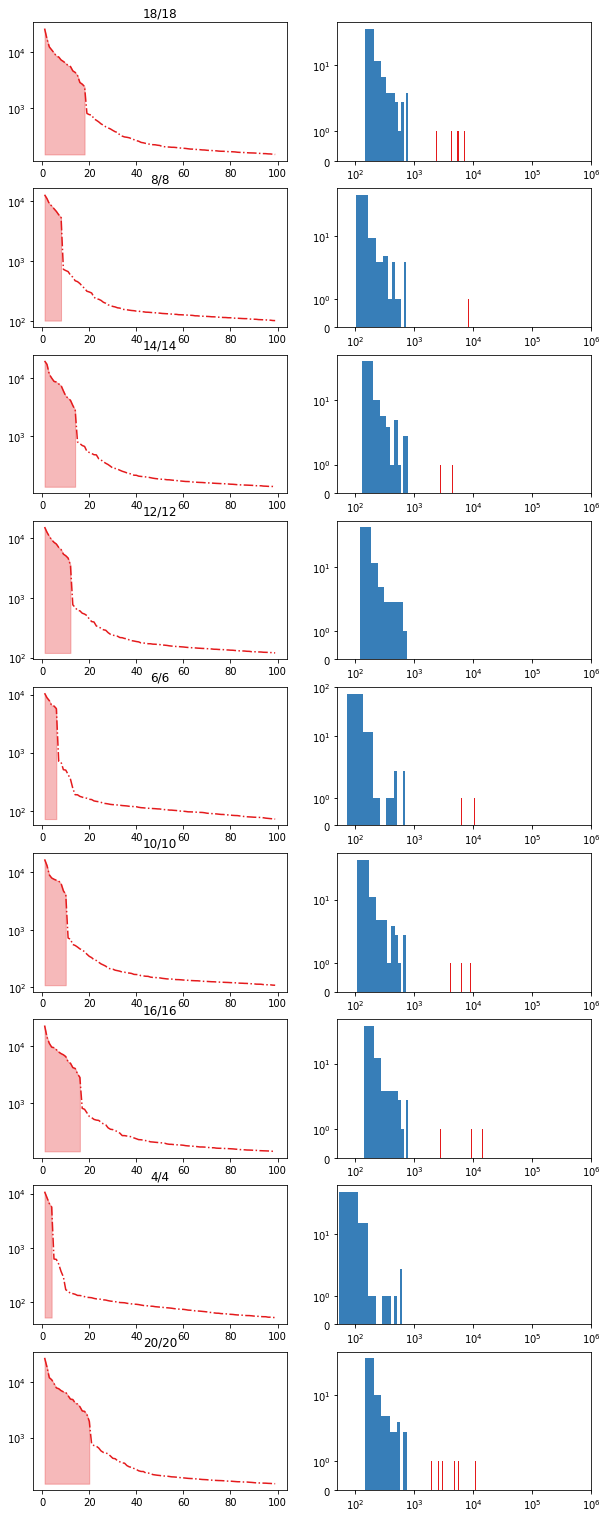

In [7]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import random_projection
from sklearn.cluster import KMeans

rootff = ''
rootfolder = rootff+'/25012019/'
realcomp = {no:cmp for no,cmp in zip(range(2,11), [20,16,12,8,4,18,14,10,6])}

datasetrange = np.arange(2,11)
datasources = [ rootfolder+ff for ff in os.listdir(rootfolder)\
               if (ff[-4:] == '.mat') and (len(ff) == 21) and 
               ff[-7:-4] in [str(a).zfill(3) for a in datasetrange]
               ]

def ftn(file):
    fileno = int(file.split('/')[-1][-7:-4])
    return realcomp[fileno]
    
datasets = [(fff,ftn(fff)) for fff in datasources]

nds = len(datasources)
plt.figure(figsize=(10,3*nds))

for idx, (fff, cmp) in enumerate(datasets):
    printProgressBar(idx+1, len(datasets))
    video_real = np.swapaxes(scipy.io.loadmat(fff)['video_data'], 0, 2)

    # remove the first frames with the ground truth
    video_real = video_real[-500:]

    # subsampling
    video_real = spkstf.bin_video(video_real, 20)
    frames_no = video_real.shape[0]
    xsize = video_real.shape[1]
    ysize = video_real.shape[2]
    X = video_real.reshape((frames_no, xsize*ysize))

    # SVD
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    svd.fit(X)  
    # remove the first larger component
    tmpv = np.log(svd.singular_values_[1:])
    
    kmeans = KMeans(n_clusters=2).fit(tmpv.reshape((-1, 1)))
    labels = kmeans.labels_
    components = sum(labels==labels[0])

    xxx = np.arange(1, len(tmpv)+1)
    tmpv = svd.singular_values_[1:]

    labels0 = tmpv[labels==labels[0]]
    labels1 = tmpv[labels==labels[-1]]

    plt.subplot(nds,2,idx*2+1)
    line, = plt.plot(xxx, tmpv, '-.', color='#e41a1c')
    plt.fill_between(xxx[labels==labels[0]], labels0, np.min(tmpv), color='#e41a1c', alpha=0.3)
    plt.yscale('symlog')
    overtext = '{}/{}'.format(components, cmp)
    plt.title(overtext)

    plt.subplot(nds,2,idx*2+2)  
    # create one bin for every eigenvalue. use the labels to do that
    binns = [(i+j) for i in labels0[::-1] for j in [-20, 20]]
    plt.hist(labels0, binns, color='#e41a1c')
    plt.hist(labels1, color='#377eb8')
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.xlim([50, 10E5])

plt.show()